## Load Libraries

In [1]:
import os
import itertools
import pickle
import json
import argparse
import datetime
import ast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from tenacity import (
    retry,
    stop_after_attempt,
    wait_random_exponential,
)
from pathlib import Path
from glob import glob
from typing import List, Tuple, Dict, Any
from openai import OpenAI
from json_repair import repair_json
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score, label_ranking_average_precision_score, coverage_error, hamming_loss, confusion_matrix, roc_auc_score, average_precision_score
from collections import defaultdict

## Qualitative Evaluation

In [2]:
def load_pickle(path):
    with open(path, mode='rb') as f:
        data=pickle.load(f)
        
    return data
    
def get_multi_label_metrics(pred, label, label_dict):

    # Invert the dictionary for name → index
    name_to_index = {v: int(k) - 1 for k, v in label_dict.items()}

    # Input
    pred_labels_str = pred
    true_labels_str = label

    # Parsing inputs
    def parse_labels(label_input):
        if isinstance(label_input, str):
            return [name.strip() for name in label_input.split(',')]
        elif isinstance(label_input, list):
            return [str(name).strip() for name in label_input]
        else:
            raise TypeError(f"Unsupported type for label_input: {type(label_input)}")

    def label_names_to_binary_vector(label_names, index_map, n_labels):
        vec = np.zeros(n_labels, dtype=int)
        for name in label_names:
            if name in index_map:
                vec[index_map[name]] = 1
        return vec

    def recall_at_k_single(y_true, y_pred_indices, k):
        y_true_set = set(np.where(y_true == 1)[0])
        if len(y_true_set) == 0:
            return 0.0
        y_pred_top_k = set(y_pred_indices[:k])
        return len(y_true_set & y_pred_top_k) / len(y_true_set)
        
    def precision_at_k_single(y_true, y_pred_indices, k):
        y_true_set = set(np.where(y_true == 1)[0])
        y_pred_top_k = set(y_pred_indices[:k])
        return len(y_true_set & y_pred_top_k) / k

    def f1_at_k_single(y_true, y_pred_indices, k):
        p = precision_at_k_single(y_true, y_pred_indices, k)
        r = recall_at_k_single(y_true, y_pred_indices, k)
        if p + r == 0:
            return 0.0
        return 2 * p * r / (p + r)

    n_labels = len(label_dict)
    
    true_names = parse_labels(true_labels_str)
    pred_names = parse_labels(pred_labels_str)

    y_true = label_names_to_binary_vector(true_names, name_to_index, n_labels)
    y_pred = label_names_to_binary_vector(pred_names, name_to_index, n_labels)

    y_scores = np.zeros(n_labels)
    for i, name in enumerate(pred_names[::-1]):
        if name in name_to_index:
            y_scores[name_to_index[name]] = i + 1

    top_k_indices = np.argsort(y_scores)[::-1]

    recall_at_10 = recall_at_k_single(y_true, top_k_indices, k=10)
    precision_at_10 = precision_at_k_single(y_true, top_k_indices, k=10)
    lrap = label_ranking_average_precision_score([y_true], [y_scores])
    cov_error = coverage_error([y_true], [y_scores])
    hamming = hamming_loss(y_true, y_pred)

    return {
        'recall@10': recall_at_10,
        'precision@10': precision_at_10,
        'LRAP': lrap,
        'coverage error': cov_error,
        'hamming loss': hamming
    }


def evaluate_multi_label_task(logits: Dict, label_dict: Dict) -> pd.DataFrame:
    try:
        labels = logits['labels']
        preds = logits['preds']
    except:
        labels = logits['labels_parental']
        preds = logits['preds_parental']
    
    all_metrics = defaultdict(list)
    valid_count = 0

    for i, (pred_i, label_i) in enumerate(zip(preds, labels)):
        if isinstance(pred_i, float) or isinstance(label_i, float):
            continue  # Skip NaN values

        try:
            metrics = get_multi_label_metrics(pred_i, label_i, label_dict)
            for k, v in metrics.items():
                all_metrics[k].append(v)
            valid_count += 1
        except Exception as e:
            print(f"Error at index {i}: {e}")
            continue

    if valid_count == 0:
        return pd.DataFrame({'count': [0]})  # Return empty if no valid inputs

    avg_metrics = {k: sum(vs) / len(vs) for k, vs in all_metrics.items()}
    data = {
        'count': [valid_count],
        **{k: [f'{v:.4f}'] for k, v in avg_metrics.items()}
    }
    return pd.DataFrame(data, index=['all'])

def get_multilabel_fairness_metrics(pred_label_str, true_label_str, label_dict) -> dict:
    name_to_index = {v: int(k) - 1 for k, v in label_dict.items()}
    n_labels = len(label_dict)

    # --- Label parsing ---
    def parse_labels(label_input):
        if isinstance(label_input, str):
            return [name.strip() for name in label_input.split(',')]
        elif isinstance(label_input, list):
            return [str(name).strip() for name in label_input]
        else:
            raise TypeError(f"Unsupported type for label_input: {type(label_input)}")

    def label_names_to_binary_vector(label_names, index_map, n_labels):
        vec = np.zeros(n_labels, dtype=int)
        for name in label_names:
            if name in index_map:
                vec[index_map[name]] = 1
        return vec

    y_true = label_names_to_binary_vector(parse_labels(true_label_str), name_to_index, n_labels)
    y_pred = label_names_to_binary_vector(parse_labels(pred_label_str), name_to_index, n_labels)

    # --- Metrics initialization ---
    tprs, fprs, fnrs, pos_rates, precisions = [], [], [], [], []

    for i in range(n_labels):
        y_t = y_true[i]
        y_p = y_pred[i]

        tp = int(y_t == 1 and y_p == 1)
        tn = int(y_t == 0 and y_p == 0)
        fp = int(y_t == 0 and y_p == 1)
        fn = int(y_t == 1 and y_p == 0)

        total = tn + fp + fn + tp
        pos_rate = (tp + fp) / total if total else 0.0
        fpr = fp / (fp + tn) if (fp + tn) else 0.0
        fnr = fn / (fn + tp) if (fn + tp) else 0.0
        tpr = tp / (tp + fn) if (tp + fn) else 0.0
        precision = tp / (tp + fp) if (tp + fp) else 0.0

        pos_rates.append(pos_rate)
        fprs.append(fpr)
        fnrs.append(fnr)
        tprs.append(tpr)
        precisions.append(precision)

    return {
        "positive_rate": np.mean(pos_rates),
        "precision (PP)": np.mean(precisions),
        "recall / tpr (EO)": np.mean(tprs),
        "fpr": np.mean(fprs),
        "fnr": np.mean(fnrs)
    }

def evaluate_multi_label_fairness(logits: Dict, label_dict: Dict) -> pd.DataFrame:
    try:
        labels = logits['labels']
        preds = logits['preds']
    except:
        labels = logits['labels_parental']
        preds = logits['preds_parental']
    
    all_metrics = defaultdict(list)
    valid_count = 0

    for i, (pred_i, label_i) in enumerate(zip(preds, labels)):
        if isinstance(pred_i, float) or isinstance(label_i, float):
            continue  # Skip NaN values

        try:
            metrics = get_multilabel_fairness_metrics(pred_i, label_i, label_dict)
            for k, v in metrics.items():
                all_metrics[k].append(v)
            valid_count += 1
        except Exception as e:
            print(f"Error at index {i}: {e}")
            continue

    if valid_count == 0:
        return pd.DataFrame({'count': [0]})

    avg_metrics = {k: sum(vs) / len(vs) for k, vs in all_metrics.items()}
    data = {
        'count': [valid_count],
        **{k: [f'{v:.4f}'] for k, v in avg_metrics.items()}
    }
    return pd.DataFrame(data, index=['all'])

In [3]:
parent_keys_dict = {
    1: "Perinatal and Congenital Conditions",
    2: "Diseases of the Blood and Immune System",
    3: "Diseases of the Circulatory System",
    4: "Diseases of the Respiratory System",
    5: "Diseases of the Digestive System",
    6: "Diseases of the Genitourinary System",
    7: "Pregnancy; Childbirth; and Postpartum Complications",
    8: "Diseases of the Musculoskeletal and Connective Tissue",
    9: "Diseases of the Nervous System and Sense Organs",
    10: "Endocrine; Nutritional; and Metabolic Diseases",
    11: "Infectious and Parasitic Diseases",
    12: "Diseases of the Skin and Subcutaneous Tissue",
    13: "Injury; Poisoning; and External Causes",
    14: "Symptoms, Signs, and Other Conditions",
    15: "Mental; Behavioral; and Neurodevelopmental Disorder",
    16: "Neoplasms",
    17: "External Causes of Morbidity (E-Codes)"
}

child_values_dict = {
  1: "Neonatal Trauma and Injury",
  2: "Other Perinatal Conditions",
  3: "Congenital Anomalies",
  4: "Anemia and Hematologic Disorders",
  5: "Immunologic Disorders",
  6: "Heart Diseases",
  7: "Hypertensive Diseases",
  8: "Cerebrovascular Disorders",
  9: "Peripheral and Venous Diseases",
  10: "Respiratory Infections",
  11: "Chronic and Obstructive Pulmonary Diseases",
  12: "Other Respiratory Conditions",
  13: "Upper Gastrointestinal Disorders",
  14: "Lower Gastrointestinal and Abdominal Disorders",
  15: "Hepatic and Pancreatic Disorders",
  16: "Oral and Dental Conditions",
  17: "Renal and Urinary Tract Disorders",
  18: "Reproductive Disorders",
  19: "Labor and Delivery Complications",
  20: "Postpartum and Puerperal Complications",
  21: "Autoimmune and Connective Tissue Disorders",
  22: "Skeletal and Acquired Musculoskeletal Disorders",
  23: "Central Nervous System Disorders",
  24: "Sensory and Vestibular Disorders",
  25: "Endocrine and Diabetic Disorders",
  26: "Nutritional and Metabolic Disorders",
  27: "Bacterial and Septic Infections",
  28: "Viral; Mycotic; and Other Infections",
  29: "Sexually Transmitted and Preventive Conditions",
  30: "Inflammatory and Infectious Skin Disorders",
  31: "Physical Trauma and Injuries",
  32: "Toxicological and Iatrogenic Complications",
  33: "Symptoms and Signs",
  34: "Aftercare and Other Issues",
  35: "Neurodevelopmental and Pediatric Disorders",
  36: "Mood; Anxiety; and Cognitive Disorders",
  37: "Psychotic and Substance Use Disorders",
  38: "Other Conditions and Events",
  39: "Gastrointestinal Cancers",
  40: "Head, Neck, and Thoracic Cancers",
  41: "Urogenital and Reproductive Cancers",
  42: "Hematologic and Endocrine Cancers",
  43: "Cancers of Other Systems",
  44: "Benign Neoplasms",
  45: "Unspecified Neoplasms and Other Conditions",
  46: "Environmental; Mechanical; and Intentional Injuries"
}

In [4]:
def get_qualitative_df(results_path):    
    
    # get the relevant chunk: "gpt-4o-mini_original_0"
    chunk = results_path.split('/')[2]
    
    # strip prefix
    items = chunk.replace("diagnosis_hierarchical", "").split("_")
    
    corruption = "_".join(items[1:-1])  # everything except first and last
    ratio = items[-1]

    print(corruption, ratio)

    save_path = results_path
    target_results_path = os.path.join(results_path, "*")
    
    i = 0
    pids, age_groups, sexs, races, insurances = list(), list(), list(), list(), list()
    preds, labels, preds_parental, labels_parental = list(), list(), list(), list()
    responses, thinks = list(), list()

    for pkl_path in glob(target_results_path):
        try:                
            pid = Path(pkl_path).stem
            age_group, sex = load_pickle(pkl_path)['age'], load_pickle(pkl_path)['sex']
            race, insurance = load_pickle(pkl_path)['race'], load_pickle(pkl_path)['insurance']
            pred, label = load_pickle(pkl_path)['pred'], load_pickle(pkl_path)['label']
            pred_parental, label_parental = load_pickle(pkl_path)['pred_parental'], load_pickle(pkl_path)['label_parental']
            response, think = load_pickle(pkl_path)['response'], load_pickle(pkl_path)['think']

            pids.append(pid)
            age_groups.append(age_group)
            sexs.append(sex)
            races.append(race)
            insurances.append(insurance)
            
            preds.append(pred)
            labels.append(label)
            preds_parental.append(pred_parental)
            labels_parental.append(label_parental)
            
            responses.append(response)
            thinks.append(think)

        except:
            i += 1

    pids = pd.Series(pids)
    age_groups = pd.Series(age_groups)
    sexs = pd.Series(sexs)
    races = pd.Series(races)
    insurances = pd.Series(insurances)
    preds = pd.Series(preds)
    labels = pd.Series(labels)
    preds_parental = pd.Series(preds_parental)
    labels_parental = pd.Series(labels_parental)
    responses = pd.Series(responses)
    thinks = pd.Series(thinks)

    results_df = pd.concat([
        pids, 
        age_groups, 
        sexs, 
        races, 
        insurances, 
        preds, 
        labels, 
        preds_parental, 
        labels_parental, 
        responses, 
        thinks
    ], axis=1).reset_index(drop=True)
    
    results_df.columns = [
        "pid", "age_group", "sex", "race", "insurance",
        "pred", "label", "pred_parental", "label_parental",
        "response", "think"
    ]
        
    results_df.to_csv(os.path.join(save_path, 'final_qualitative_df.csv'), index=False)
        
    return results_df

## Performance Quantitative Evaluation

In [57]:
def combine_performance(dfs, metric='recall'):

    assert len(dfs) >= 1, "At least one DataFrame is required."

    prefixes = ['lab', 'copy', 'ocr', 'homo']

    if metric in ['recall', 'precision']:
        base_cols = [
            'subgroup',
            f'{metric}@10_mean_clean',
            f'{metric}@10_relwidth_clean'
        ]
    elif metric in ['recall / tpr (EO)', 'fpr']:
        base_cols = [
            'subgroup',
            f'{metric}_mean_clean',
            f'{metric}_relwidth_clean'
        ]
        
    combined_df = dfs[0][base_cols].copy()

    # Add the rest with prefixes
    for df, prefix in zip(dfs[1:], prefixes):
        if metric in ['recall', 'precision']:
            corrupt_cols = [
                f'{metric}@10_mean_corrupt',
                f'{metric}@10_relwidth_corrupt'
            ]
        elif metric in ['recall / tpr (EO)', 'fpr']:
            corrupt_cols = [
                f'{metric}_mean_corrupt',
                f'{metric}_relwidth_corrupt'
            ]
        temp = df[corrupt_cols].copy()
        temp.columns = [f'{prefix}_{c}' for c in temp.columns]
        combined_df = pd.concat([combined_df, temp], axis=1)

    return combined_df

In [6]:
def get_performance_quantitative_df(qualitative_path, child_values_dict):

    # Todo's -> csv save

    # Load Data #
    csv_path = os.path.join(qualitative_path, 'final_qualitative_df.csv')
    results_df = pd.read_csv(csv_path)

    # get the relevant chunk: "gpt-4o-mini_original_0"
    chunk = qualitative_path.split('/')[2]
    
    # strip prefix
    items = chunk.replace("diagnosis_hierarchical", "").split("_")
    
    corruption = "_".join(items[1:-1])  # everything except first and last
    ratio = items[-1]

    # Overall Results #
    overall_results_df = evaluate_multi_label_task({'labels': results_df.label.tolist(), 'preds': results_df.pred.tolist()}, child_values_dict)

    # Sub-group Results #
    subgroup_results_list = list()    
    subgroup_cols = ["age_group", "sex", "race"]
    for subgroup_col in tqdm(subgroup_cols):
        if subgroup_col not in results_df.columns:
            raise ValueError(f"Group column '{group_col}' not found in data.")
    
        for subgroup_value, subgroup_df in results_df.groupby(subgroup_col):
    
            labels = subgroup_df["label"].tolist()
            preds = subgroup_df["pred"].tolist()
    
            subgroup_results = evaluate_multi_label_task({
                'labels': labels,
                'preds': preds,
            }, child_values_dict)
            
            subgroup_results['corruption'] = corruption            
            subgroup_results['ratio'] = ratio
            
            subgroup_results['criteria'] = subgroup_col            
            subgroup_results['sub_group'] = subgroup_value
            subgroup_results_list.append(subgroup_results)
    
    subgroup_results_df = pd.concat(subgroup_results_list)
            
    subgroup_results_df.columns = [
        "count", "recall@10", "precision@10", "LRAP", "coverage error", "hamming loss", "corruption", "ratio", "criteria", "sub_group"
    ]		
    
    subgroup_results_df = subgroup_results_df[[
        "corruption", "ratio", "criteria", "sub_group", "count", 
        "recall@10", "precision@10", "LRAP", "coverage error", "hamming loss"
    ]]
    
    subgroup_results_df = subgroup_results_df.reset_index(drop=True)

    # Patient-wise Results #
    patient_results_list = list()

    for i in range(len(results_df)):
        temp_results_df = evaluate_multi_label_task({'labels': [results_df.label[i]], 'preds': [results_df.pred[i]]}, child_values_dict)    
        temp_results_df['pid'] = results_df.pid[i] 
        temp_results_df['age'] = results_df.age_group[i]             
        temp_results_df['sex'] = results_df.sex[i]          
        temp_results_df['race'] = results_df.race[i] 
    
        temp_results_df.drop(['count'], axis=1)
        
        patient_results_list.append(temp_results_df)
        
    patient_results_df = pd.concat(patient_results_list)
    patient_results_df = patient_results_df[[
        "pid", "age", "sex", "race", "recall@10", "precision@10", "LRAP", "coverage error", "hamming loss"
    ]]
    
    patient_results_df = patient_results_df.reset_index(drop=True)

    def get_bootstrap_overall_df(df, corruption, ratio, metrics=["recall@10", "precision@10"], 
                                 n_boot=2000, ci=95, random_state=42):
        """
        Bootstrap confidence intervals for the whole dataset (ignores subgroups).
        """
        # Ensure numeric metrics
        for col in metrics:
            df[col] = pd.to_numeric(df[col], errors="coerce")
        
        np.random.seed(random_state)
    
        group_size = len(df)
        metric_boot = {m: [] for m in metrics}
    
        # Bootstrap sampling across the whole dataframe
        for _ in range(n_boot):
            sample = df.sample(n=group_size, replace=True)
            for m in metrics:
                metric_boot[m].append(sample[m].mean())
    
        res = {
            "corruption": corruption,
            "ratio": ratio,
            "criteria": "overall",
            "subgroup": "all",
            "count": group_size
        }
    
        for m in metrics:
            scores = np.array(metric_boot[m])
            lower = np.percentile(scores, (100-ci)/2)
            upper = np.percentile(scores, 100-(100-ci)/2)
            mean_val = scores.mean()
            ci_width = upper - lower
            rel_width = ci_width / mean_val if mean_val != 0 else np.nan
        
            res[f"{m}_mean"] = np.round(mean_val, 4)
            res[f"{m}_{ci}CI"] = (np.round(lower, 4), np.round(upper, 4))
            res[f"{m}_{ci}CI_width"] = np.round(ci_width, 4)
            res[f"{m}_{ci}CI_relwidth"] = np.round(rel_width, 4)
    
        col_order = ["corruption", "ratio", "criteria", "subgroup", "count"] + \
            [f"{m}_mean" for m in metrics] + \
            [f"{m}_{ci}CI" for m in metrics] + \
            [f"{m}_{ci}CI_width" for m in metrics] + \
            [f"{m}_{ci}CI_relwidth" for m in metrics]
    
        return pd.DataFrame([res])[col_order]
    
    def get_bootstrap_subgroup_df(df, corruption, ratio, group_col, metrics=["recall@10", "precision@10"], n_boot=2000, ci=95, random_state=42):
    
        for col in ["recall@10", "precision@10"]:
            df[col] = pd.to_numeric(df[col], errors="coerce")
        
        np.random.seed(random_state)
        results = []
    
        for group_val, group_df in tqdm(df.groupby(group_col)):
            group_size = len(group_df)
            metric_boot = {m: [] for m in metrics}
    
            for _ in range(n_boot):
                sample = group_df.sample(n=group_size, replace=True)
                for m in metrics:
                    metric_boot[m].append(sample[m].mean())
    
            res = {
                "corruption": corruption,
                "ratio": ratio,
                "criteria": f"{group_col}_group",
                "subgroup": group_val,
                "count": group_size
            }
            
            for m in metrics:
                scores = np.array(metric_boot[m])
                lower = np.percentile(scores, (100-ci)/2)
                upper = np.percentile(scores, 100-(100-ci)/2)
                mean_val = scores.mean()
                ci_width = upper - lower
                rel_width = ci_width / mean_val if mean_val != 0 else np.nan
            
                res[f"{m}_mean"] = np.round(mean_val, 4)
                res[f"{m}_{ci}CI"] = (np.round(lower, 4), np.round(upper, 4))
                res[f"{m}_{ci}CI_width"] = np.round(ci_width, 4)
                res[f"{m}_{ci}CI_relwidth"] = np.round(rel_width, 4)
                
            results.append(res)
    
        col_order = ["corruption", "ratio", "criteria", "subgroup", "count"] + \
            [f"{m}_mean" for m in metrics] + \
            [f"{m}_{ci}CI" for m in metrics] + \
            [f"{m}_{ci}CI_width" for m in metrics] + \
            [f"{m}_{ci}CI_relwidth" for m in metrics]
        
        return pd.DataFrame(results)[col_order]

    bootstrap_overall_results_df = get_bootstrap_overall_df(patient_results_df, corruption, ratio, )

    bootstrap_subgroup_age_results_df  = get_bootstrap_subgroup_df(patient_results_df, corruption, ratio, group_col="age")
    bootstrap_subgroup_sex_results_df  = get_bootstrap_subgroup_df(patient_results_df, corruption, ratio, group_col="sex")
    bootstrap_subgroup_race_results_df = get_bootstrap_subgroup_df(patient_results_df, corruption, ratio, group_col="race")

    bootstrap_subgroup_results_df = pd.concat([bootstrap_subgroup_age_results_df, bootstrap_subgroup_sex_results_df, bootstrap_subgroup_race_results_df], axis=0)
    bootstrap_subgroup_results_df = bootstrap_subgroup_results_df.reset_index(drop=True)

    return overall_results_df, subgroup_results_df, patient_results_df, bootstrap_overall_results_df, bootstrap_subgroup_results_df

## Fairness Quantitative Evaluation

In [8]:
def get_fairness_quantitative_df(qualitative_path, child_values_dict):

    # Todo's -> csv save

    # Load Data #
    csv_path = os.path.join(qualitative_path, 'final_qualitative_df.csv')
    results_df = pd.read_csv(csv_path)
    
    
    # get the relevant chunk: "gpt-4o-mini_original_0"
    chunk = qualitative_path.split('/')[2]
    
    # strip prefix
    items = chunk.replace("diagnosis_hierarchical", "").split("_")
    
    corruption = "_".join(items[1:-1])  # everything except first and last
    ratio = items[-1]

    # Overall Results #
    overall_results_df = evaluate_multi_label_fairness({'labels': results_df.label.tolist(), 'preds': results_df.pred.tolist()}, child_values_dict)

    # Sub-group Results #
    subgroup_results_list = list()    
    subgroup_cols = ["age_group", "sex", "race"]
    for subgroup_col in tqdm(subgroup_cols):
        if subgroup_col not in results_df.columns:
            raise ValueError(f"Group column '{group_col}' not found in data.")
    
        for subgroup_value, subgroup_df in results_df.groupby(subgroup_col):
    
            labels = subgroup_df["label"].tolist()
            preds = subgroup_df["pred"].tolist()
    
            subgroup_results = evaluate_multi_label_fairness({
                'labels': labels,
                'preds': preds,
            }, child_values_dict)
             
            subgroup_results['corruption'] = corruption            
            subgroup_results['ratio'] = ratio
            
            subgroup_results['criteria'] = subgroup_col            
            subgroup_results['sub_group'] = subgroup_value
            subgroup_results_list.append(subgroup_results)
    
    subgroup_results_df = pd.concat(subgroup_results_list)
            
    subgroup_results_df.columns = [
        "count", "positive_rate", "precision (PP)", "recall / tpr (EO)", "fpr", "fnr", "corruption", "ratio", "criteria", "sub_group"
    ]		
    
    subgroup_results_df = subgroup_results_df[[
        "corruption", "ratio", "criteria", "sub_group", "count", 
        "positive_rate", "precision (PP)", "recall / tpr (EO)", "fpr", "fnr"
    ]]
    
    subgroup_results_df = subgroup_results_df.reset_index(drop=True)

    # Patient-wise Results #
    patient_results_list = list()

    for i in range(len(results_df)):
        temp_results_df = evaluate_multi_label_fairness({'labels': [results_df.label[i]], 'preds': [results_df.pred[i]]}, child_values_dict)
        temp_results_df['pid'] = results_df.pid[i] 
        temp_results_df['age'] = results_df.age_group[i]             
        temp_results_df['sex'] = results_df.sex[i]          
        temp_results_df['race'] = results_df.race[i] 
    
        temp_results_df.drop(['count'], axis=1)
        
        patient_results_list.append(temp_results_df)
        
    patient_results_df = pd.concat(patient_results_list)
    patient_results_df = patient_results_df[[
        "pid", "age", "sex", "race", "positive_rate", "precision (PP)", "recall / tpr (EO)", "fpr", "fnr"
    ]]
    
    patient_results_df = patient_results_df.reset_index(drop=True)

    def get_bootstrap_overall_df(df, corruption, ratio, metrics=["precision (PP)", "recall / tpr (EO)"], 
                                 n_boot=2000, ci=95, random_state=42):
        """
        Bootstrap confidence intervals for the whole dataset (ignores subgroups).
        """
        # Ensure numeric metrics
        for col in metrics:
            df[col] = pd.to_numeric(df[col], errors="coerce")
        
        np.random.seed(random_state)
    
        group_size = len(df)
        metric_boot = {m: [] for m in metrics}
    
        # Bootstrap sampling across the whole dataframe
        for _ in range(n_boot):
            sample = df.sample(n=group_size, replace=True)
            for m in metrics:
                metric_boot[m].append(sample[m].mean())
    
        res = {
            "corruption": corruption,
            "ratio": ratio,
            "criteria": "overall",
            "subgroup": "all",
            "count": group_size
        }
    
        for m in metrics:
            scores = np.array(metric_boot[m])
            lower = np.percentile(scores, (100-ci)/2)
            upper = np.percentile(scores, 100-(100-ci)/2)
            mean_val = scores.mean()
            ci_width = upper - lower
            rel_width = ci_width / mean_val if mean_val != 0 else np.nan
        
            res[f"{m}_mean"] = np.round(mean_val, 4)
            res[f"{m}_{ci}CI"] = (np.round(lower, 4), np.round(upper, 4))
            res[f"{m}_{ci}CI_width"] = np.round(ci_width, 4)
            res[f"{m}_{ci}CI_relwidth"] = np.round(rel_width, 4)
    
        col_order = ["corruption", "ratio", "criteria", "subgroup", "count"] + \
            [f"{m}_mean" for m in metrics] + \
            [f"{m}_{ci}CI" for m in metrics] + \
            [f"{m}_{ci}CI_width" for m in metrics] + \
            [f"{m}_{ci}CI_relwidth" for m in metrics]
    
        return pd.DataFrame([res])[col_order]
    
    def get_bootstrap_subgroup_df(df, corruption, ratio, group_col, metrics=["precision (PP)", "recall / tpr (EO)"], n_boot=2000, ci=95, random_state=42):
    
        for col in ["recall / tpr (EO)", "fpr"]:
            df[col] = pd.to_numeric(df[col], errors="coerce")
        
        np.random.seed(random_state)
        results = []
    
        for group_val, group_df in tqdm(df.groupby(group_col)):
            group_size = len(group_df)
            metric_boot = {m: [] for m in metrics}
    
            for _ in range(n_boot):
                sample = group_df.sample(n=group_size, replace=True)
                for m in metrics:
                    metric_boot[m].append(sample[m].mean())
    
            res = {
                "corruption": corruption,
                "ratio": ratio,
                "criteria": f"{group_col}_group",
                "subgroup": group_val,
                "count": group_size
            }
            
            for m in metrics:
                scores = np.array(metric_boot[m])
                lower = np.percentile(scores, (100-ci)/2)
                upper = np.percentile(scores, 100-(100-ci)/2)
                mean_val = scores.mean()
                ci_width = upper - lower
                rel_width = ci_width / mean_val if mean_val != 0 else np.nan
            
                res[f"{m}_mean"] = np.round(mean_val, 4)
                res[f"{m}_{ci}CI"] = (np.round(lower, 4), np.round(upper, 4))
                res[f"{m}_{ci}CI_width"] = np.round(ci_width, 4)
                res[f"{m}_{ci}CI_relwidth"] = np.round(rel_width, 4)
                
            results.append(res)
    
        col_order = ["corruption", "ratio", "criteria", "subgroup", "count"] + \
            [f"{m}_mean" for m in metrics] + \
            [f"{m}_{ci}CI" for m in metrics] + \
            [f"{m}_{ci}CI_width" for m in metrics] + \
            [f"{m}_{ci}CI_relwidth" for m in metrics]
        
        return pd.DataFrame(results)[col_order]

    bootstrap_overall_results_df = get_bootstrap_overall_df(patient_results_df, corruption, ratio, )

    bootstrap_subgroup_age_results_df  = get_bootstrap_subgroup_df(patient_results_df, corruption, ratio, group_col="age")
    bootstrap_subgroup_sex_results_df  = get_bootstrap_subgroup_df(patient_results_df, corruption, ratio, group_col="sex")
    bootstrap_subgroup_race_results_df = get_bootstrap_subgroup_df(patient_results_df, corruption, ratio, group_col="race")

    bootstrap_subgroup_results_df = pd.concat([bootstrap_subgroup_age_results_df, bootstrap_subgroup_sex_results_df, bootstrap_subgroup_race_results_df], axis=0)
    bootstrap_subgroup_results_df = bootstrap_subgroup_results_df.reset_index(drop=True)

    return overall_results_df, subgroup_results_df, patient_results_df, bootstrap_overall_results_df, bootstrap_subgroup_results_df

## Visualization

In [9]:
def compare_clean_corrupt(df_clean, df_corrupt, group_col, metrics=["recall@10", "precision@10"], n_boot=2000, ci=95):
    """
    Compare clean vs corrupt instability by subgroup.

    df_clean, df_corrupt: DataFrames with subgroup + metric columns
    group_col: subgroup identifier column (e.g., "race", "age", "sex")
    metrics: list of metrics to analyze
    """

    def bootstrap_ci(values, n_boot=2000, ci=95, random_state=42):
        """Bootstrap CI and relative width for a given set of values"""
        np.random.seed(random_state)
        n = len(values)
        means = []
        for _ in range(n_boot):
            sample = np.random.choice(values, size=n, replace=True)
            means.append(np.mean(sample))
        means = np.array(means)
    
        lower = np.percentile(means, (100 - ci) / 2)
        upper = np.percentile(means, 100 - (100 - ci) / 2)
        mean_val = means.mean()
        ci_width = upper - lower
        rel_width = ci_width / mean_val if mean_val != 0 else np.nan
    
        return mean_val, (lower, upper), ci_width, rel_width
    
    results = []

    for subgroup in df_clean[group_col].unique():
        row = {"subgroup": subgroup}

        for m in metrics:
            vals_clean = pd.to_numeric(df_clean[df_clean[group_col] == subgroup][m], errors="coerce").dropna().values
            vals_corrupt = pd.to_numeric(df_corrupt[df_corrupt[group_col] == subgroup][m], errors="coerce").dropna().values

            if len(vals_clean) == 0 or len(vals_corrupt) == 0:
                continue  # skip if subgroup missing

            # Bootstrap CI for clean & corrupt
            mean_clean, ci_clean, width_clean, relwidth_clean = bootstrap_ci(vals_clean, n_boot=n_boot, ci=ci)
            mean_corrupt, ci_corrupt, width_corrupt, relwidth_corrupt = bootstrap_ci(vals_corrupt, n_boot=n_boot, ci=ci)

            # Save results
            row.update({
                f"{m}_mean_clean": np.round(mean_clean, 4),
                f"{m}_{ci}CI_clean": tuple(np.round(ci_clean, 4)),
                f"{m}_relwidth_clean": np.round(relwidth_clean, 4),

                f"{m}_mean_corrupt": np.round(mean_corrupt, 4),
                f"{m}_{ci}CI_corrupt": tuple(np.round(ci_corrupt, 4)),
                f"{m}_relwidth_corrupt": np.round(relwidth_corrupt, 4)
            })

        results.append(row)

    return pd.DataFrame(results)

In [10]:
def _half_errors_from_relwidth(means, relwidths):
    """Return symmetric half-error lengths from relative widths around means."""
    means = np.asarray(means, dtype=float)
    relwidths = np.asarray(relwidths, dtype=float)
    half = 0.5 * relwidths * means
    return half, half

In [94]:
def plot_models_subgroups_metrics_mean(
    models_dict,
    corruption_labels,
    metrics=("recall@10", "precision@10"),
    subgroup_order=None,
    subgroup_col="subgroup",
    figsize=(24, 16),
    model_spacing=1.0,
    corruption_spacing=0.10,
    pad_frac=0.1,
    text_offset=0.015,
    bottom_margin=0.12,
    title="Figure_Mean_Performance_by_Subgroup",
):
    """
    Plot subgroup-wise performance across multiple models and corruption types.
    X-axis = metric mean value (e.g., recall@10, precision@10).
    Errorbar lengths derived from relwidth × mean.
    Text label shows mean / relwidth.
    """

    model_names = list(models_dict.keys())
    n_models = len(model_names)
    n_subgroups = len(subgroup_order)
    n_metrics = len(metrics)

    fig, axes = plt.subplots(
        n_metrics, n_subgroups, figsize=figsize, sharey=False, squeeze=False
    )

    # --- color map for (model, corruption) pairs ---
    n_colors = n_models * (len(corruption_labels) + 1)
    color_cycle = plt.cm.tab20(np.linspace(0, 1, n_colors))
    color_map = {}
    c_idx = 0
    for model in model_names:
        color_map[(model, "Clean")] = color_cycle[c_idx]; c_idx += 1
        for cl in corruption_labels:
            color_map[(model, cl)] = color_cycle[c_idx]; c_idx += 1

    for m_idx, metric in enumerate(metrics):
        for s_idx, subgroup in enumerate(subgroup_order):
            ax = axes[m_idx, s_idx]
            all_lowers, all_uppers = [], []

            for mi, model_name in enumerate(model_names):
                df_clean, df_list_corrupt = models_dict[model_name]
                dfc = df_clean[df_clean[subgroup_col] == subgroup]
                corrupt_dfs = [df[df[subgroup_col] == subgroup] for df in df_list_corrupt]
                base_y = mi * model_spacing

                # --- Clean case ---
                mean_clean = dfc[f"{metric}_mean_clean"].values[0]
                rel_clean = dfc[f"{metric}_relwidth_clean"].values[0]
                lo, hi = _half_errors_from_relwidth([mean_clean], [rel_clean])

                ax.errorbar(
                    mean_clean, base_y,
                    xerr=[[lo[0]], [hi[0]]],
                    fmt="o", capsize=12, elinewidth=1.8,
                    color=color_map[(model_name, "Clean")],
                    label=f"{model_name} Clean" if (s_idx == 0 and m_idx == 0) else None,
                )
                ax.text(
                    mean_clean,
                    base_y - text_offset,
                    f"{mean_clean:.3f} / {rel_clean:.3f}",
                    fontsize=16,
                    va="bottom", ha="center", color="black"
                )

                all_lowers.append(mean_clean - lo[0])
                all_uppers.append(mean_clean + hi[0])

                # --- Corruptions ---
                for j, (df_corrupt, clabel) in enumerate(zip(corrupt_dfs, corruption_labels), start=1):
                    mean_c = df_corrupt[f"{metric}_mean_corrupt"].values[0]
                    rel_c = df_corrupt[f"{metric}_relwidth_corrupt"].values[0]
                    ypos_c = base_y + j * corruption_spacing
                    lo, hi = _half_errors_from_relwidth([mean_c], [rel_c])

                    ax.errorbar(
                        mean_c, ypos_c,
                        xerr=[[lo[0]], [hi[0]]],
                        fmt="s", capsize=12, elinewidth=1.8,
                        color=color_map[(model_name, clabel)],
                        label=f"{model_name} {clabel}" if (s_idx == 0 and m_idx == 0) else None,
                    )
                    ax.text(
                        mean_c,
                        ypos_c - text_offset,
                        f"{mean_c:.3f} / {rel_c:.3f}",
                        fontsize=16,
                        va="bottom", ha="center", color="black"
                    )

                    all_lowers.append(mean_c - lo[0])
                    all_uppers.append(mean_c + hi[0])

            # --- Dynamic x-axis ---
            xmin, xmax = min(all_lowers), max(all_uppers)
            pad = pad_frac * (xmax - xmin if xmax > xmin else 1.0)
            ax.set_xlim(xmin - pad, xmax + pad)
            ax.tick_params(axis="x", labelrotation=25)
            ax.set_title(f"{metric.upper()} @ {subgroup}", fontsize=20, weight="bold")
            ax.grid(axis="x", linestyle="--", alpha=0.4)
            ax.set_yticks([])

    # --- Legend ---
    handles, labels = axes[0, 0].get_legend_handles_labels()
    plt.subplots_adjust(hspace=0.5, bottom=bottom_margin)
    plt.rcParams.update({"font.size": 10})

    fig.legend(
        handles, labels,
        loc="lower center",
        bbox_to_anchor=(0.5, -0.01),
        ncol=len(labels) // 2,
        fontsize=14,
        frameon=False
    )

    plt.tight_layout(rect=[0, 0.05, 1, 1])
    plt.savefig(f"{title}.pdf", dpi=300, bbox_inches="tight")
    plt.show()

In [95]:
import numpy as np
import matplotlib.pyplot as plt


def _half_errors_from_relwidth(means, relwidths):
    """Compute symmetric half-errors for mean-based uncertainty visualization."""
    means = np.asarray(means, dtype=float)
    relwidths = np.asarray(relwidths, dtype=float)
    half = 0.5 * relwidths * means
    return half, half


def plot_multiple_models_dicts(
    models_dicts,
    corruption_labels,
    metrics_list,             # list of tuples, one per models_dict
    subgroup_order=None,
    subgroup_col="subgroup",
    figsize=None,
    model_spacing=0.6,
    corruption_spacing=0.12,
    pad_frac=0.1,
    text_offset=0.05,
    titles=None,              # optional row titles
    bottom_margin=0.12,
    title="Figure_Disparities_by_AGE",
    save_path=None
):
    """
    Multi-row layout: each row corresponds to one models_dict input.
    Each row can have its own metrics.
    Each data point shows mean ± (relwidth * mean / 2) as horizontal errorbar,
    with text annotations showing "mean / relwidth".
    """

    n_rows = len(models_dicts)
    if titles is None:
        titles = [f"Row {i+1}" for i in range(n_rows)]

    # compute panels per row dynamically
    n_panels_per_row = [len(metrics) * len(subgroup_order) for metrics in metrics_list]

    # Figure size: width by max panels
    if figsize is None:
        figsize = (min(6 * max(n_panels_per_row), 36), 6 * n_rows)

    fig, axes = plt.subplots(
        n_rows, max(n_panels_per_row),
        figsize=figsize,
        squeeze=False
    )

    for row_idx, (models_dict, metrics) in enumerate(zip(models_dicts, metrics_list)):
        model_names = list(models_dict.keys())
        n_subgroups = len(subgroup_order)
        n_panels = len(metrics) * n_subgroups

        # --- Color map ---
        n_colors = len(model_names) * (len(corruption_labels) + 1)
        color_cycle = plt.cm.tab20(np.linspace(0, 1, n_colors))
        color_map = {}
        c_idx = 0
        for model in model_names:
            color_map[(model, "Clean")] = color_cycle[c_idx]; c_idx += 1
            for cl in corruption_labels:
                color_map[(model, cl)] = color_cycle[c_idx]; c_idx += 1

        # --- Plot each metric × subgroup ---
        for ax_idx in range(n_panels):
            ax = axes[row_idx, ax_idx]
            m_idx = ax_idx // n_subgroups
            s_idx = ax_idx % n_subgroups
            metric = metrics[m_idx]
            subgroup = subgroup_order[s_idx]

            all_lowers, all_uppers = [], []

            for mi, model_name in enumerate(model_names):
                df_clean, df_list_corrupt = models_dict[model_name]
                dfc = df_clean[df_clean[subgroup_col] == subgroup]
                corrupt_dfs = [df[df[subgroup_col] == subgroup] for df in df_list_corrupt]
                base_y = mi * model_spacing

                # --- Clean ---
                mean_clean = dfc[f"{metric}_mean_clean"].values[0]
                rel_clean = dfc[f"{metric}_relwidth_clean"].values[0]
                lo, hi = _half_errors_from_relwidth([mean_clean], [rel_clean])

                ax.errorbar(
                    mean_clean, base_y,
                    xerr=[[lo[0]], [hi[0]]],
                    fmt="o", capsize=12, elinewidth=1.8,
                    color=color_map[(model_name, "Clean")],
                    label=f"{model_name} Clean" if (row_idx == 0 and ax_idx == 0) else None,
                )

                ax.text(
                    mean_clean, base_y - text_offset,
                    f"{mean_clean:.3f} / {rel_clean:.3f}",
                    fontsize=16, va="bottom", ha="center", color="black"
                )

                all_lowers.append(mean_clean - lo[0])
                all_uppers.append(mean_clean + hi[0])

                # --- Corruptions ---
                for j, (df_corrupt, clabel) in enumerate(zip(corrupt_dfs, corruption_labels), start=1):
                    mean_c = df_corrupt[f"{metric}_mean_corrupt"].values[0]
                    rel_c = df_corrupt[f"{metric}_relwidth_corrupt"].values[0]
                    lo, hi = _half_errors_from_relwidth([mean_c], [rel_c])
                    ypos = base_y + j * corruption_spacing

                    ax.errorbar(
                        mean_c, ypos,
                        xerr=[[lo[0]], [hi[0]]],
                        fmt="s", capsize=12, elinewidth=1.8,
                        color=color_map[(model_name, clabel)],
                        label=f"{model_name} {clabel}" if (row_idx == 0 and ax_idx == 0) else None,
                    )

                    ax.text(
                        mean_c, ypos - text_offset,
                        f"{mean_c:.3f} / {rel_c:.3f}",
                        fontsize=16, va="bottom", ha="center", color="black"
                    )

                    all_lowers.append(mean_c - lo[0])
                    all_uppers.append(mean_c + hi[0])

            # --- X-axis limits ---
            xmin, xmax = min(all_lowers), max(all_uppers)
            pad = pad_frac * (xmax - xmin if xmax > xmin else 1.0)
            ax.set_xlim(xmin - pad, xmax + pad)
            ax.tick_params(axis="x", labelrotation=25)
            ax.set_title(f"{metric.upper()} @ {subgroup}", fontsize=16, weight="bold")
            ax.grid(axis="x", linestyle="--", alpha=0.4)
            ax.set_yticks([])

        # --- Empty unused axes in this row ---
        for ax_idx in range(n_panels, max(n_panels_per_row)):
            axes[row_idx, ax_idx].axis("off")

        # --- Row title ---
        axes[row_idx, 0].set_ylabel(titles[row_idx], fontsize=16, weight="bold")

    # --- Global Legend ---
    handles, labels = axes[0, 0].get_legend_handles_labels()
    plt.subplots_adjust(hspace=0.5, bottom=bottom_margin)
    plt.rcParams.update({"font.size": 10})
    
    fig.legend(
        handles, labels,
        loc="lower center",
        bbox_to_anchor=(0.5, -0.03),
        ncol=len(labels) // 2,
        fontsize=14,
        frameon=False
    )

    # fig.legend(
    #     handles, labels,
    #     loc="center left",           # anchor relative to right side
    #     bbox_to_anchor=(1.02, 0.5),  # just outside the figure (x > 1 moves right)
    #     ncol=1,                      # 1 column → vertical stack
    #     fontsize=14,
    #     frameon=False
    # )

    plt.tight_layout(rect=[0, 0.05, 1, 0.98])

    if save_path is None:
        save_path = f"{title}.pdf"
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()

## Diagnostic Longtailness

In [13]:
def get_diagnostic_longtail_analysis(df_dict, criteria=None, reference="original"):
    mlb = MultiLabelBinarizer(classes=list(child_values_dict.values()))
    mlb.fit(list(child_values_dict.values()))

    # --- Step 1: compute label count from reference dataset only ---
    ref_df = df_dict[reference]
    if criteria == "18-40":
        ref_df = ref_df[ref_df["age_group"] == "18–40"]
    if criteria == "ASIAN":
        ref_df = ref_df[ref_df["race"] == "ASIAN"]

    ref_df = ref_df.copy()
    ref_df["label_list"] = ref_df["label"].str.split(",\s*")
    y_true_ref = mlb.transform(ref_df["label_list"])
    label_count = y_true_ref.sum(axis=0)

    # Put into DataFrame
    label_count_df = pd.DataFrame({
        "Disease": mlb.classes_,
        "Label Count": label_count
    })

    all_results = []

    # --- Step 2: compute AUROC per dataset ---
    for name, df in df_dict.items():
        if criteria == "18-40":
            df = df[df["age_group"] == "18–40"]

        df = df.copy()
        df["pred_list"] = df["pred"].str.split(",\s*")
        df["label_list"] = df["label"].str.split(",\s*")

        y_true = mlb.transform(df["label_list"])
        y_pred = mlb.transform(df["pred_list"])

        results = []
        for i, disease in enumerate(mlb.classes_):
            y_true_col = y_true[:, i]
            y_pred_col = y_pred[:, i]

            if y_true_col.sum() == 0:
                auroc = np.nan
            else:
                try:
                    auroc = roc_auc_score(y_true_col, y_pred_col)
                except ValueError:
                    auroc = np.nan
                try:
                    auprc = average_precision_score(y_true_col, y_pred_col)
                except ValueError:
                    auprc = np.nan

            results.append((disease, auprc))

        df_results = pd.DataFrame(results, columns=["Disease", f"{name}_AUPRC"])
        all_results.append(df_results)

    merged = label_count_df
    for other in all_results:
        merged = pd.merge(merged, other, on="Disease", how="left")

    merged = merged.sort_values(by="Label Count", ascending=False).reset_index(drop=True)

    return merged

## CSV Files

In [15]:
qualitative_path = "./results_diagnosis_hierarchical_demo/gemini-2.0-flash_original_0/qualitative/"
get_qualitative_df(qualitative_path)
_, _, gemini_original_patient_results_df, _, gemini_original_bootstrap_subgroup_results_df = get_performance_quantitative_df(qualitative_path, child_values_dict)
_, _, gemini_original_patient_results_fairness_df, _, gemini_original_bootstrap_subgroup_results_fairness_df = get_fairness_quantitative_df(qualitative_path, child_values_dict)

qualitative_path = "./results_diagnosis_hierarchical_demo/gemini-2.0-flash_random_lab_values_erasure_1/qualitative/"
get_qualitative_df(qualitative_path)
_, _, gemini_lab_patient_results_df, _, gemini_lab_bootstrap_subgroup_results_df = get_performance_quantitative_df(qualitative_path, child_values_dict)
_, _, gemini_lab_patient_results_fairness_df, _, gemini_lab_bootstrap_subgroup_results_fairness_df = get_fairness_quantitative_df(qualitative_path, child_values_dict)

qualitative_path = "./results_diagnosis_hierarchical_demo/gemini-2.0-flash_copy_paste_from_previous_0.8/qualitative/"
get_qualitative_df(qualitative_path)
_, _, gemini_copy_patient_results_df, _, gemini_copy_bootstrap_subgroup_results_df = get_performance_quantitative_df(qualitative_path, child_values_dict)
_, _, gemini_copy_patient_results_fairness_df, _, gemini_copy_bootstrap_subgroup_results_fairness_df = get_fairness_quantitative_df(qualitative_path, child_values_dict)

qualitative_path = "./results_diagnosis_hierarchical_demo/gemini-2.0-flash_ocr_corrupt_document_0.3/qualitative/"
get_qualitative_df(qualitative_path)
_, _, gemini_ocr_patient_results_df, _, gemini_ocr_bootstrap_subgroup_results_df = get_performance_quantitative_df(qualitative_path, child_values_dict)
_, _, gemini_ocr_patient_results_fairness_df, _, gemini_ocr_bootstrap_subgroup_results_fairness_df = get_fairness_quantitative_df(qualitative_path, child_values_dict)

qualitative_path = "./results_diagnosis_hierarchical_demo/gemini-2.0-flash_replace_with_homophones_fast_0.3/qualitative/"
get_qualitative_df(qualitative_path)
_, _, gemini_homo_patient_results_df, _, gemini_homo_bootstrap_subgroup_results_df = get_performance_quantitative_df(qualitative_path, child_values_dict)
_, _, gemini_homo_patient_results_fairness_df, _, gemini_homo_bootstrap_subgroup_results_fairness_df = get_fairness_quantitative_df(qualitative_path, child_values_dict)

original 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:05<00:00,  1.19it/s]


random_lab_values_erasure 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:05<00:00,  1.19it/s]


copy_paste_from_previous 0.8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:04<00:00,  1.27it/s]


ocr_corrupt_document 0.3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:04<00:00,  1.22it/s]


replace_with_homophones_fast 0.3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:04<00:00,  1.29it/s]


In [14]:
qualitative_path = "./results_diagnosis_hierarchical_demo/gpt-4o-mini_original_0/qualitative/"
get_qualitative_df(qualitative_path)
_, _, gpt4omini_original_patient_results_df, _, _ = get_performance_quantitative_df(qualitative_path, child_values_dict)
_, _, gpt4omini_original_patient_results_fairness_df, _, _ = get_fairness_quantitative_df(qualitative_path, child_values_dict)

qualitative_path = "./results_diagnosis_hierarchical_demo/gpt-4o-mini_random_lab_values_erasure_1/qualitative/"
get_qualitative_df(qualitative_path)
_, _, gpt4omini_lab_patient_results_df, _, _ = get_performance_quantitative_df(qualitative_path, child_values_dict)
_, _, gpt4omini_lab_patient_results_fairness_df, _, _ = get_fairness_quantitative_df(qualitative_path, child_values_dict)

qualitative_path = "./results_diagnosis_hierarchical_demo/gpt-4o-mini_copy_paste_from_previous_0.8/qualitative/"
get_qualitative_df(qualitative_path)
_, _, gpt4omini_copy_patient_results_df, _, _ = get_performance_quantitative_df(qualitative_path, child_values_dict)
_, _, gpt4omini_copy_patient_results_fairness_df, _, _ = get_fairness_quantitative_df(qualitative_path, child_values_dict)

qualitative_path = "./results_diagnosis_hierarchical_demo/gpt-4o-mini_ocr_corrupt_document_0.3/qualitative/"
get_qualitative_df(qualitative_path)
_, _, gpt4omini_ocr_patient_results_df, _, _ = get_performance_quantitative_df(qualitative_path, child_values_dict)
_, _, gpt4omini_ocr_patient_results_fairness_df, _, _ = get_fairness_quantitative_df(qualitative_path, child_values_dict)

qualitative_path = "./results_diagnosis_hierarchical_demo/gpt-4o-mini_replace_with_homophones_fast_0.3/qualitative/"
get_qualitative_df(qualitative_path)
_, _, gpt4omini_homo_patient_results_df, _, _ = get_performance_quantitative_df(qualitative_path, child_values_dict)
_, _, gpt4omini_homo_patient_results_fairness_df, _, _ = get_fairness_quantitative_df(qualitative_path, child_values_dict)

original 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:05<00:00,  1.16it/s]


random_lab_values_erasure 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:05<00:00,  1.20it/s]


copy_paste_from_previous 0.8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:04<00:00,  1.23it/s]


ocr_corrupt_document 0.3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:04<00:00,  1.23it/s]


replace_with_homophones_fast 0.3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:04<00:00,  1.27it/s]


## Race

In [16]:
results_gemini_race_lab = compare_clean_corrupt(gemini_original_patient_results_df, gemini_lab_patient_results_df, group_col="race")
results_gemini_race_copy = compare_clean_corrupt(gemini_original_patient_results_df, gemini_copy_patient_results_df, group_col="race")
results_gemini_race_ocr = compare_clean_corrupt(gemini_original_patient_results_df, gemini_ocr_patient_results_df, group_col="race")
results_gemini_race_homo = compare_clean_corrupt(gemini_original_patient_results_df, gemini_homo_patient_results_df, group_col="race")

results_gemini_fairness_race_lab = compare_clean_corrupt(gemini_original_patient_results_fairness_df, gemini_lab_patient_results_fairness_df, group_col="race", metrics=["recall / tpr (EO)", "fpr"])
results_gemini_fairness_race_copy = compare_clean_corrupt(gemini_original_patient_results_fairness_df, gemini_copy_patient_results_fairness_df, group_col="race", metrics=["recall / tpr (EO)", "fpr"])
results_gemini_fairness_race_ocr = compare_clean_corrupt(gemini_original_patient_results_fairness_df, gemini_ocr_patient_results_fairness_df, group_col="race", metrics=["recall / tpr (EO)", "fpr"])
results_gemini_fairness_race_homo = compare_clean_corrupt(gemini_original_patient_results_fairness_df, gemini_homo_patient_results_fairness_df, group_col="race", metrics=["recall / tpr (EO)", "fpr"])

In [17]:
results_gpt4omini_race_lab = compare_clean_corrupt(gpt4omini_original_patient_results_df, gpt4omini_lab_patient_results_df, group_col="race")
results_gpt4omini_race_copy = compare_clean_corrupt(gpt4omini_original_patient_results_df, gpt4omini_copy_patient_results_df, group_col="race")
results_gpt4omini_race_ocr = compare_clean_corrupt(gpt4omini_original_patient_results_df, gpt4omini_ocr_patient_results_df, group_col="race")
results_gpt4omini_race_homo = compare_clean_corrupt(gpt4omini_original_patient_results_df, gpt4omini_homo_patient_results_df, group_col="race")

results_gpt4omini_fairness_race_lab = compare_clean_corrupt(gpt4omini_original_patient_results_fairness_df, gpt4omini_lab_patient_results_fairness_df, group_col="race", metrics=["recall / tpr (EO)", "fpr"])
results_gpt4omini_fairness_race_copy = compare_clean_corrupt(gpt4omini_original_patient_results_fairness_df, gpt4omini_copy_patient_results_fairness_df, group_col="race", metrics=["recall / tpr (EO)", "fpr"])
results_gpt4omini_fairness_race_ocr = compare_clean_corrupt(gpt4omini_original_patient_results_fairness_df, gpt4omini_ocr_patient_results_fairness_df, group_col="race", metrics=["recall / tpr (EO)", "fpr"])
results_gpt4omini_fairness_race_homo = compare_clean_corrupt(gpt4omini_original_patient_results_fairness_df, gpt4omini_homo_patient_results_fairness_df, group_col="race", metrics=["recall / tpr (EO)", "fpr"])

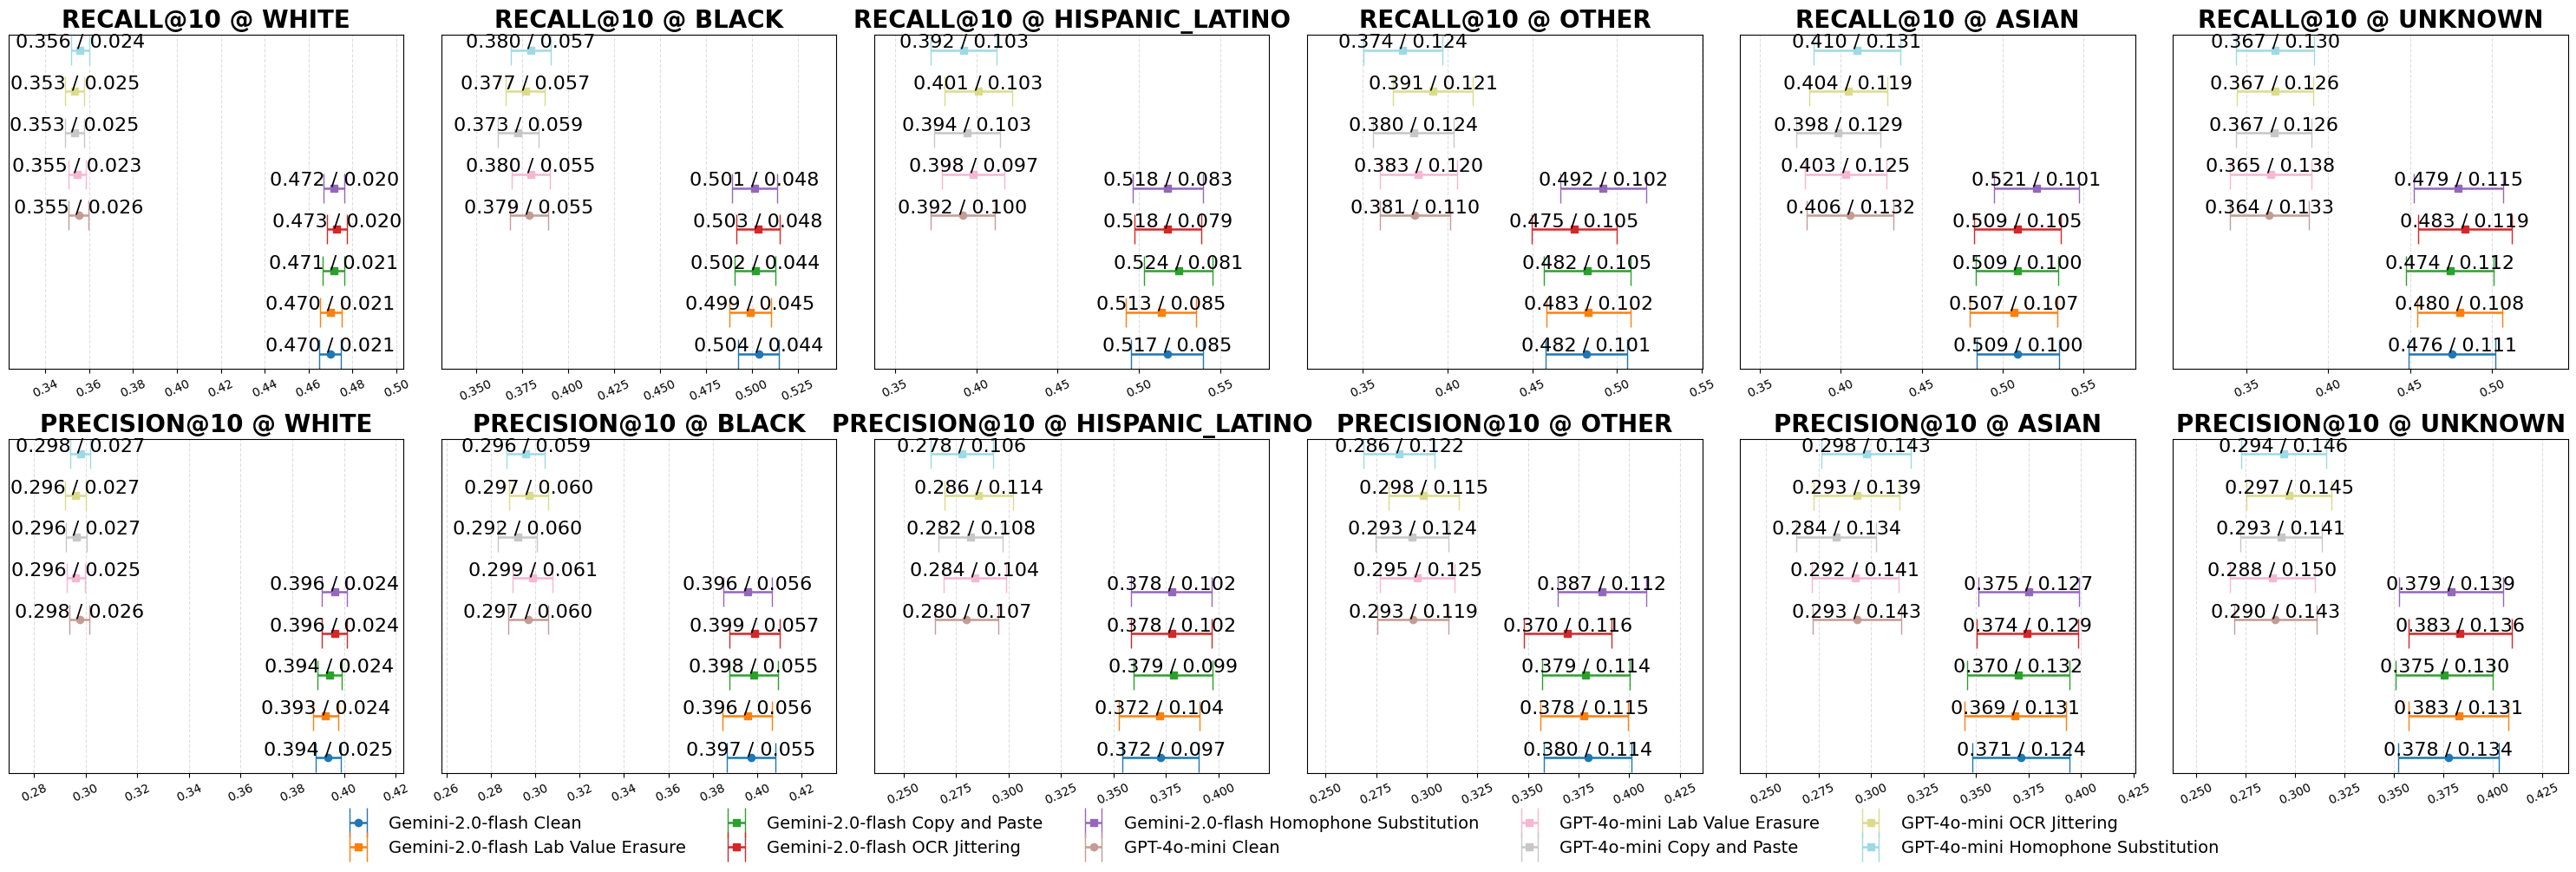

In [100]:
models_dict = {
    "Gemini-2.0-flash": (results_gemini_race_lab, [results_gemini_race_lab, results_gemini_race_copy, results_gemini_race_ocr, results_gemini_race_homo]),
    "GPT-4o-mini": (results_gpt4omini_race_lab, [results_gpt4omini_race_lab, results_gpt4omini_race_copy, results_gpt4omini_race_ocr, results_gpt4omini_race_homo]),
}

plot_models_subgroups_metrics_mean(
    models_dict,
    corruption_labels=["Lab Value Erasure", "Copy and Paste", "OCR Jittering", "Homophone Substitution"],
    metrics=("recall@10", "precision@10"),
    subgroup_order=['WHITE', 'BLACK', 'HISPANIC_LATINO', 'OTHER', 'ASIAN', 'UNKNOWN'],
    subgroup_col="subgroup",
    figsize=(30, 10),
    model_spacing=1.0,
    corruption_spacing=0.3,
    pad_frac=0.2,
    text_offset=0.005,
    bottom_margin=0.2,
    title="Figure_Performance_Disparities_by_RACE"
)

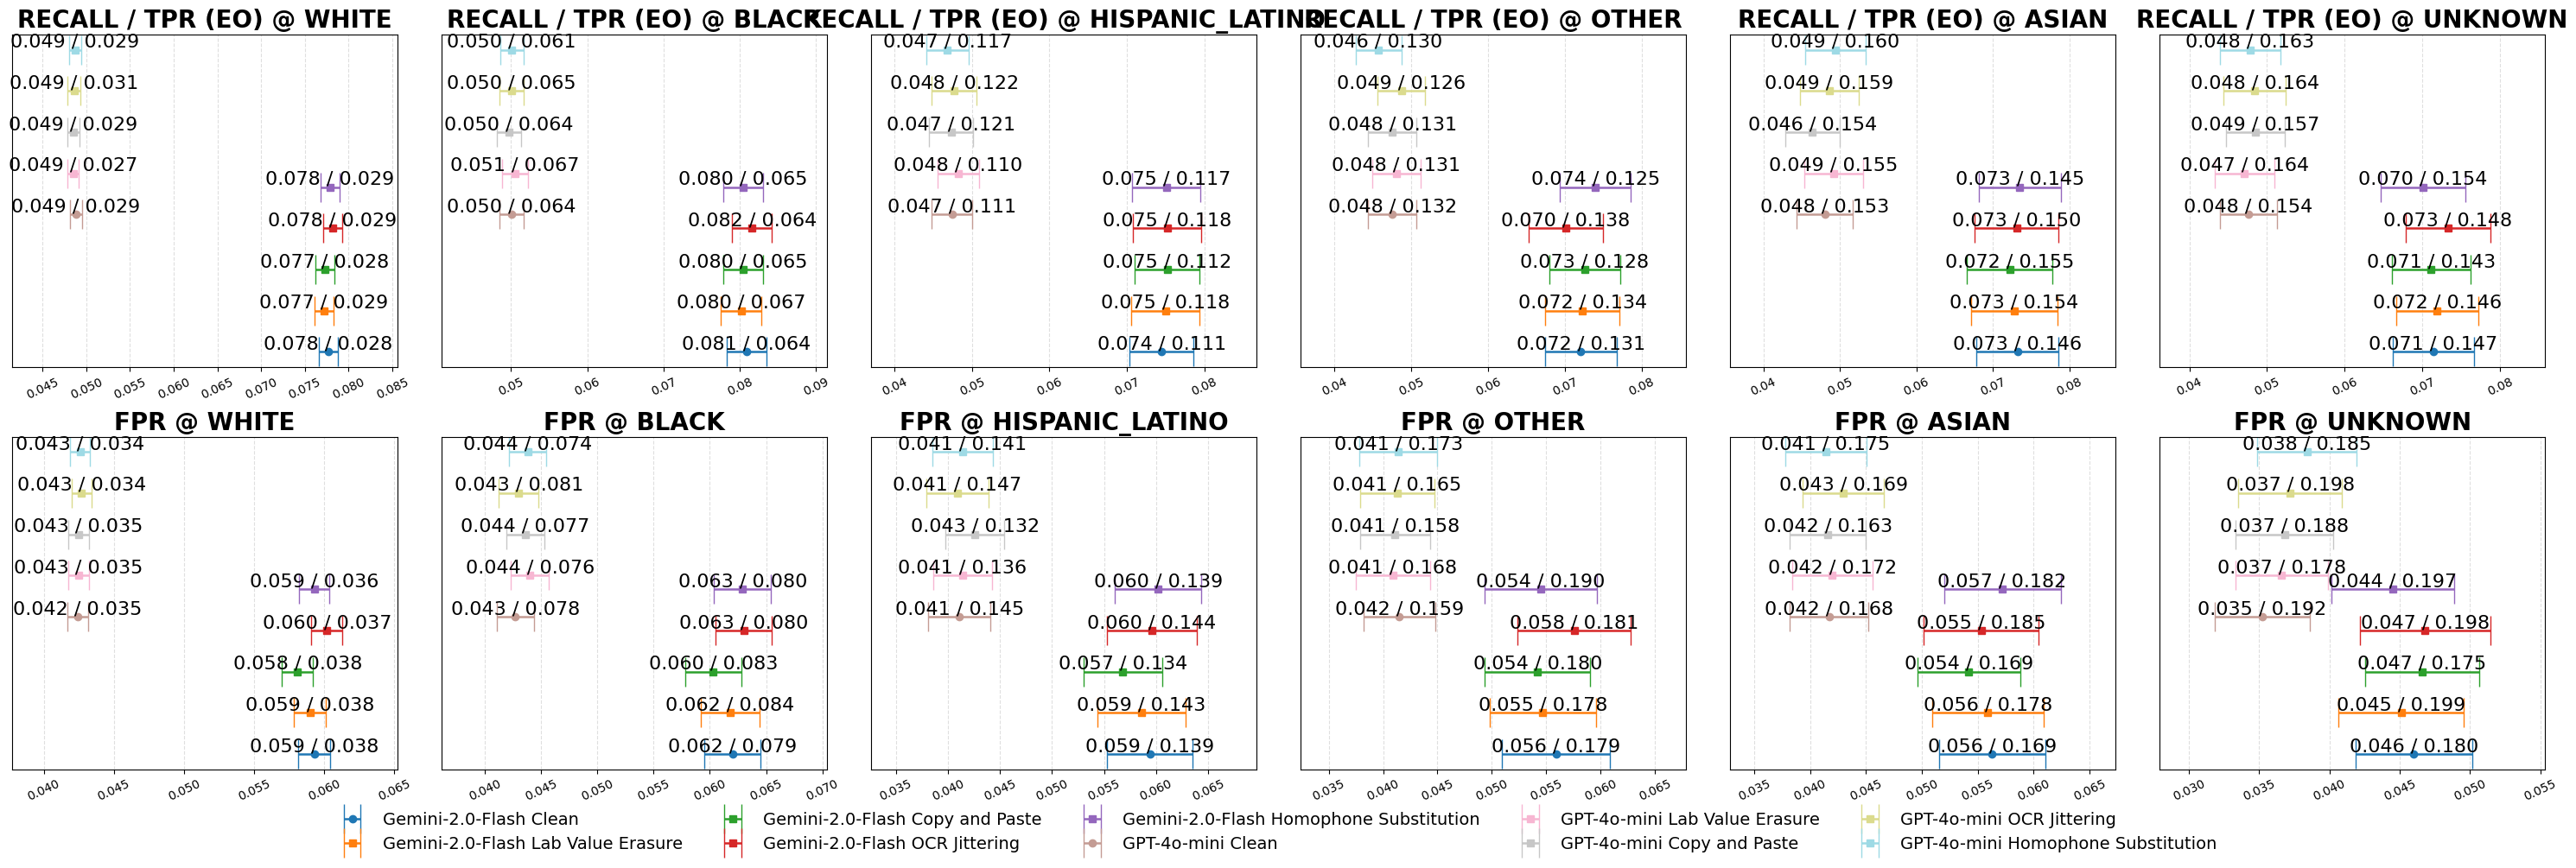

In [101]:
models_dict = {
    "Gemini-2.0-Flash": (results_gemini_fairness_race_lab, 
                         [results_gemini_fairness_race_lab, results_gemini_fairness_race_copy, results_gemini_fairness_race_ocr, results_gemini_fairness_race_homo]
                        ),
    "GPT-4o-mini": (results_gpt4omini_fairness_race_lab, 
                    [results_gpt4omini_fairness_race_lab, results_gpt4omini_fairness_race_copy, results_gpt4omini_fairness_race_ocr, results_gpt4omini_fairness_race_homo]
                   ),
}

plot_models_subgroups_metrics_mean(
    models_dict,
    corruption_labels=["Lab Value Erasure", "Copy and Paste", "OCR Jittering", "Homophone Substitution"],
    metrics=("recall / tpr (EO)", "fpr"),
    subgroup_order=['WHITE', 'BLACK', 'HISPANIC_LATINO', 'OTHER', 'ASIAN', 'UNKNOWN'],
    subgroup_col="subgroup",
    figsize=(30, 10),
    model_spacing=1.0,
    corruption_spacing=0.3,
    pad_frac=0.2,
    text_offset=0.005,
    bottom_margin=0.2,
    title="Figure_Fairness_Disparities_by_RACE"
)

## AGE

In [20]:
results_gemini_age_lab = compare_clean_corrupt(gemini_original_patient_results_df, gemini_lab_patient_results_df, group_col="age")
results_gemini_age_copy = compare_clean_corrupt(gemini_original_patient_results_df, gemini_copy_patient_results_df, group_col="age")
results_gemini_age_ocr = compare_clean_corrupt(gemini_original_patient_results_df, gemini_ocr_patient_results_df, group_col="age")
results_gemini_age_homo = compare_clean_corrupt(gemini_original_patient_results_df, gemini_homo_patient_results_df, group_col="age")

results_gemini_fairness_age_lab = compare_clean_corrupt(gemini_original_patient_results_fairness_df, gemini_lab_patient_results_fairness_df, group_col="age", metrics=["recall / tpr (EO)", "fpr"])
results_gemini_fairness_age_copy = compare_clean_corrupt(gemini_original_patient_results_fairness_df, gemini_copy_patient_results_fairness_df, group_col="age", metrics=["recall / tpr (EO)", "fpr"])
results_gemini_fairness_age_ocr = compare_clean_corrupt(gemini_original_patient_results_fairness_df, gemini_ocr_patient_results_fairness_df, group_col="age", metrics=["recall / tpr (EO)", "fpr"])
results_gemini_fairness_age_homo = compare_clean_corrupt(gemini_original_patient_results_fairness_df, gemini_homo_patient_results_fairness_df, group_col="age", metrics=["recall / tpr (EO)", "fpr"])

In [21]:
results_gpt4omini_age_lab = compare_clean_corrupt(gpt4omini_original_patient_results_df, gpt4omini_lab_patient_results_df, group_col="age")
results_gpt4omini_age_copy = compare_clean_corrupt(gpt4omini_original_patient_results_df, gpt4omini_copy_patient_results_df, group_col="age")
results_gpt4omini_age_ocr = compare_clean_corrupt(gpt4omini_original_patient_results_df, gpt4omini_ocr_patient_results_df, group_col="age")
results_gpt4omini_age_homo = compare_clean_corrupt(gpt4omini_original_patient_results_df, gpt4omini_homo_patient_results_df, group_col="age")

results_gpt4omini_fairness_age_lab = compare_clean_corrupt(gpt4omini_original_patient_results_fairness_df, gpt4omini_lab_patient_results_fairness_df, group_col="age", metrics=["recall / tpr (EO)", "fpr"])
results_gpt4omini_fairness_age_copy = compare_clean_corrupt(gpt4omini_original_patient_results_fairness_df, gpt4omini_copy_patient_results_fairness_df, group_col="age", metrics=["recall / tpr (EO)", "fpr"])
results_gpt4omini_fairness_age_ocr = compare_clean_corrupt(gpt4omini_original_patient_results_fairness_df, gpt4omini_ocr_patient_results_fairness_df, group_col="age", metrics=["recall / tpr (EO)", "fpr"])
results_gpt4omini_fairness_age_homo = compare_clean_corrupt(gpt4omini_original_patient_results_fairness_df, gpt4omini_homo_patient_results_fairness_df, group_col="age", metrics=["recall / tpr (EO)", "fpr"])

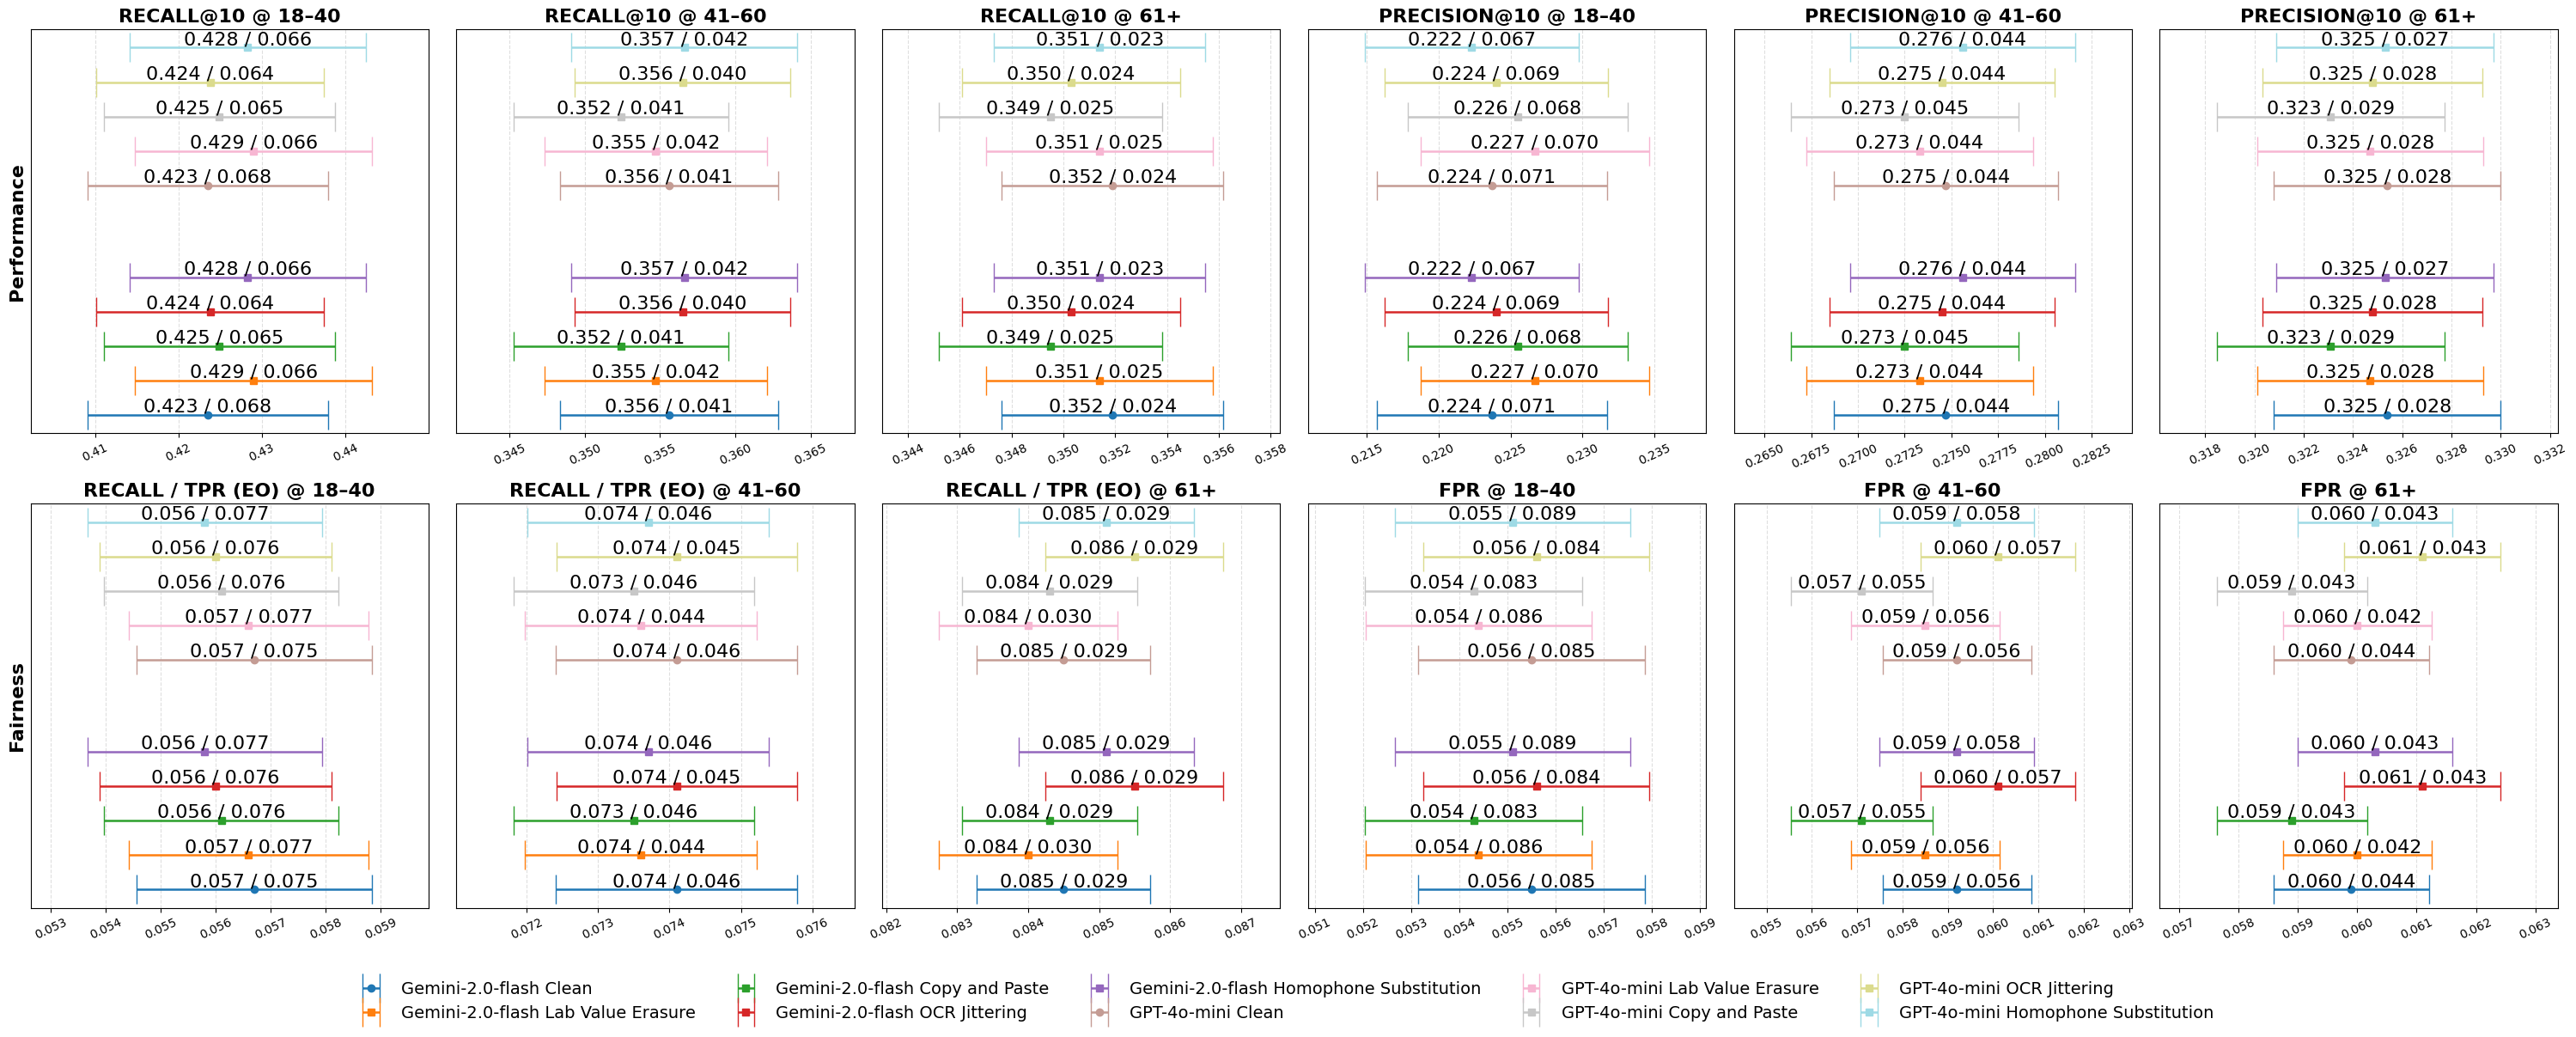

In [103]:
models_dict_fairness = {
    "Gemini-2.0-flash": (results_gemini_fairness_age_lab, [results_gemini_fairness_age_lab, results_gemini_fairness_age_copy, results_gemini_fairness_age_ocr, results_gemini_fairness_age_homo]),
    "GPT-4o-mini": (results_gemini_fairness_age_lab, [results_gemini_fairness_age_lab, results_gemini_fairness_age_copy, results_gemini_fairness_age_ocr, results_gemini_fairness_age_homo]),
}

models_dict_original = {
    "Gemini-2.0-flash": (results_gpt4omini_age_lab, [results_gpt4omini_age_lab, results_gpt4omini_age_copy, results_gpt4omini_age_ocr, results_gpt4omini_age_homo]),
    "GPT-4o-mini": (results_gpt4omini_age_lab, [results_gpt4omini_age_lab, results_gpt4omini_age_copy, results_gpt4omini_age_ocr, results_gpt4omini_age_homo]),
}

plot_multiple_models_dicts(
    models_dicts=[models_dict_original, models_dict_fairness],
    corruption_labels=["Lab Value Erasure", "Copy and Paste", "OCR Jittering", "Homophone Substitution"],
    metrics_list=[
        ("recall@10", "precision@10"),         # for original dict
        ("recall / tpr (EO)", "fpr")           # for fairness dict
    ],
    subgroup_order=['18–40', '41–60', '61+'],
    subgroup_col="subgroup",
    figsize=(30, 12),
    model_spacing=2.0,
    corruption_spacing=0.3,
    pad_frac=0.2,
    text_offset=0.005,
    bottom_margin=0.2,
    titles=["Performance", "Fairness"],
    title="Performance_Fairness_Disparities_by_AGE"
)

## Sex

In [23]:
results_gemini_sex_lab = compare_clean_corrupt(gemini_original_patient_results_df, gemini_lab_patient_results_df, group_col="sex")
results_gemini_sex_copy = compare_clean_corrupt(gemini_original_patient_results_df, gemini_copy_patient_results_df, group_col="sex")
results_gemini_sex_ocr = compare_clean_corrupt(gemini_original_patient_results_df, gemini_ocr_patient_results_df, group_col="sex")
results_gemini_sex_homo = compare_clean_corrupt(gemini_original_patient_results_df, gemini_homo_patient_results_df, group_col="sex")

results_gemini_fairness_sex_lab = compare_clean_corrupt(gemini_original_patient_results_fairness_df, gemini_lab_patient_results_fairness_df, group_col="sex", metrics=["recall / tpr (EO)", "fpr"])
results_gemini_fairness_sex_copy = compare_clean_corrupt(gemini_original_patient_results_fairness_df, gemini_copy_patient_results_fairness_df, group_col="sex", metrics=["recall / tpr (EO)", "fpr"])
results_gemini_fairness_sex_ocr = compare_clean_corrupt(gemini_original_patient_results_fairness_df, gemini_ocr_patient_results_fairness_df, group_col="sex", metrics=["recall / tpr (EO)", "fpr"])
results_gemini_fairness_sex_homo = compare_clean_corrupt(gemini_original_patient_results_fairness_df, gemini_homo_patient_results_fairness_df, group_col="sex", metrics=["recall / tpr (EO)", "fpr"])

In [24]:
results_gpt4omini_sex_lab = compare_clean_corrupt(gpt4omini_original_patient_results_df, gpt4omini_lab_patient_results_df, group_col="sex")
results_gpt4omini_sex_copy = compare_clean_corrupt(gpt4omini_original_patient_results_df, gpt4omini_copy_patient_results_df, group_col="sex")
results_gpt4omini_sex_ocr = compare_clean_corrupt(gpt4omini_original_patient_results_df, gpt4omini_ocr_patient_results_df, group_col="sex")
results_gpt4omini_sex_homo = compare_clean_corrupt(gpt4omini_original_patient_results_df, gpt4omini_homo_patient_results_df, group_col="sex")

results_gpt4omini_fairness_sex_lab = compare_clean_corrupt(gpt4omini_original_patient_results_fairness_df, gpt4omini_lab_patient_results_fairness_df, group_col="sex", metrics=["recall / tpr (EO)", "fpr"])
results_gpt4omini_fairness_sex_copy = compare_clean_corrupt(gpt4omini_original_patient_results_fairness_df, gpt4omini_copy_patient_results_fairness_df, group_col="sex", metrics=["recall / tpr (EO)", "fpr"])
results_gpt4omini_fairness_sex_ocr = compare_clean_corrupt(gpt4omini_original_patient_results_fairness_df, gpt4omini_ocr_patient_results_fairness_df, group_col="sex", metrics=["recall / tpr (EO)", "fpr"])
results_gpt4omini_fairness_sex_homo = compare_clean_corrupt(gpt4omini_original_patient_results_fairness_df, gpt4omini_homo_patient_results_fairness_df, group_col="sex", metrics=["recall / tpr (EO)", "fpr"])

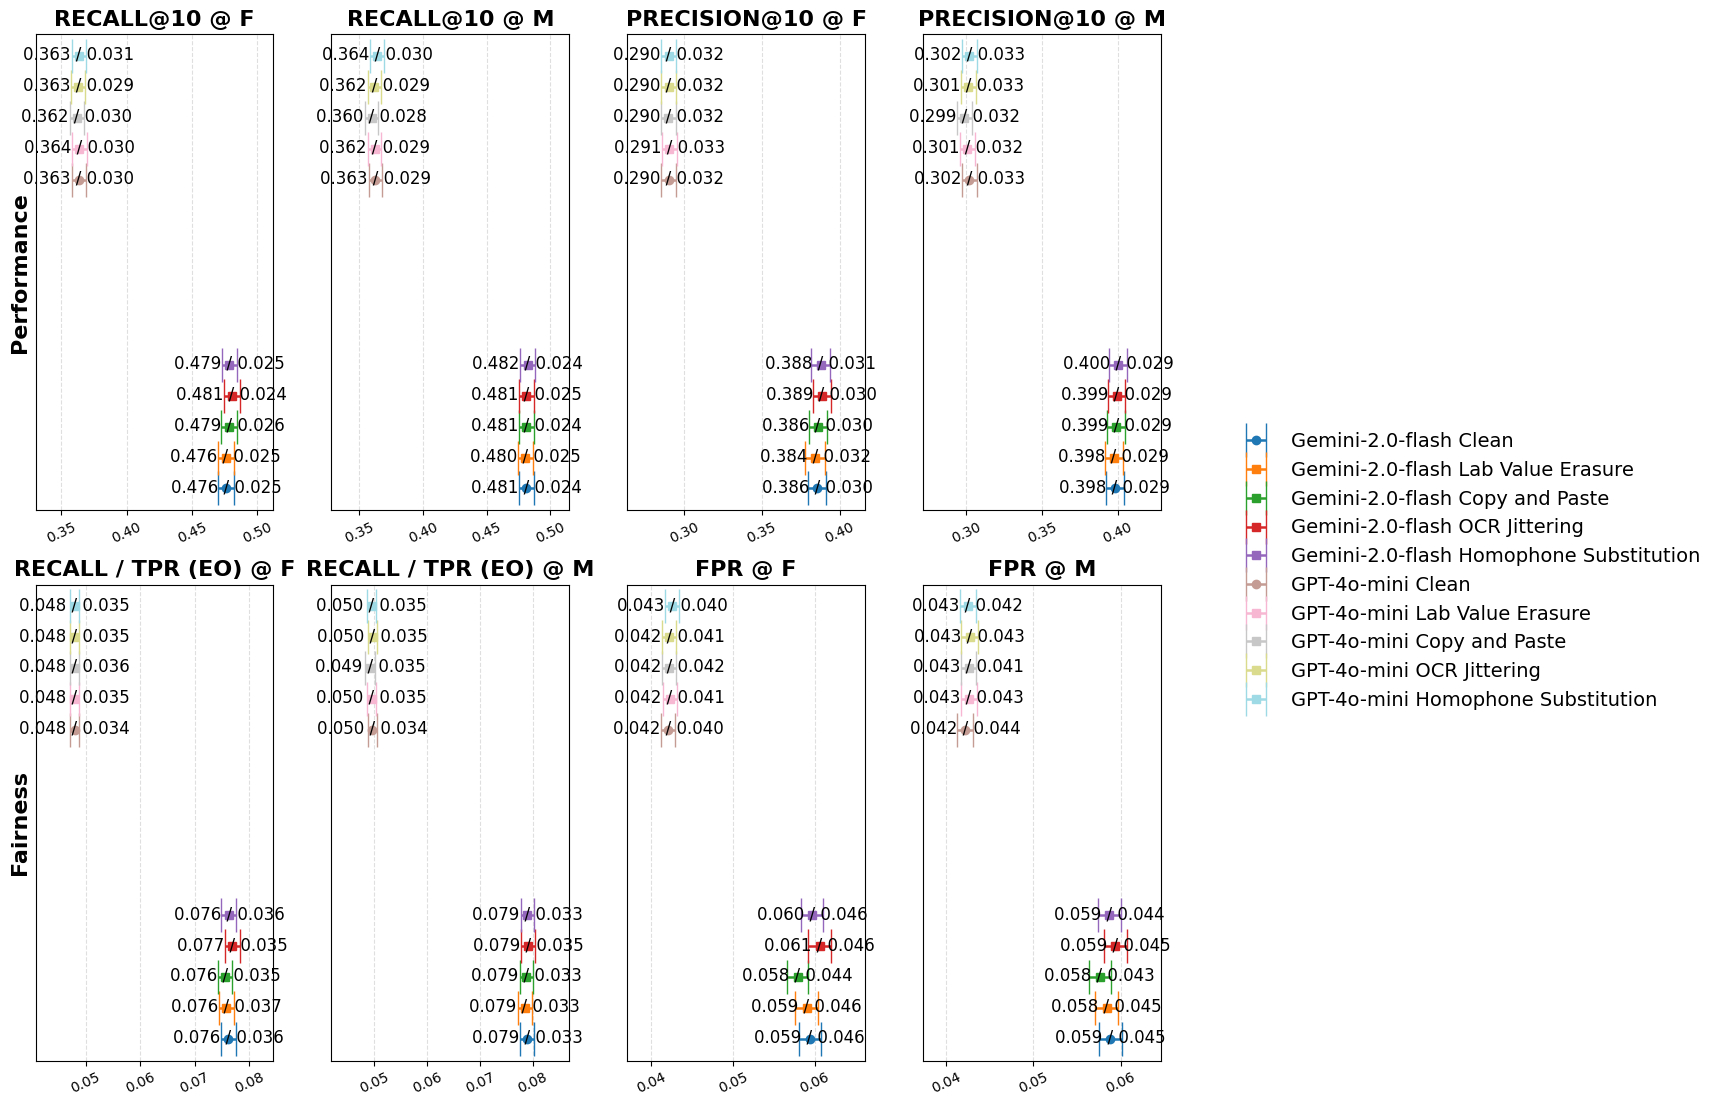

In [31]:
models_dict_fairness = {
    "Gemini-2.0-flash": (results_gemini_fairness_sex_lab, 
                    [results_gemini_fairness_sex_lab, results_gemini_fairness_sex_copy, results_gemini_fairness_sex_ocr, results_gemini_fairness_sex_homo]
                   ),
    "GPT-4o-mini": (results_gpt4omini_fairness_sex_lab, 
                    [results_gpt4omini_fairness_sex_lab, results_gpt4omini_fairness_sex_copy, results_gpt4omini_fairness_sex_ocr, results_gpt4omini_fairness_sex_homo]
                   ),
}

models_dict_original = {
    "Gemini-2.0-flash": (results_gemini_sex_lab, [results_gemini_sex_lab, results_gemini_sex_copy, results_gemini_sex_ocr, results_gemini_sex_homo]),
    "GPT-4o-mini": (results_gpt4omini_sex_lab, [results_gpt4omini_sex_lab, results_gpt4omini_sex_copy, results_gpt4omini_sex_ocr, results_gpt4omini_sex_homo]),
}

plot_multiple_models_dicts(
    models_dicts=[models_dict_original, models_dict_fairness],
    corruption_labels=["Lab Value Erasure", "Copy and Paste", "OCR Jittering", "Homophone Substitution"],
    metrics_list=[
        ("recall@10", "precision@10"),         # for original dict
        ("recall / tpr (EO)", "fpr")           # for fairness dict
    ],
    subgroup_order=['F', 'M'],
    subgroup_col="subgroup",
    figsize=(12, 12),
    model_spacing=1.0,
    corruption_spacing=0.10,
    pad_frac=0.2,
    text_offset=0.025,
    bottom_margin=0.15,
    titles=["Performance", "Fairness"],
    title="Performance_Fairness_Disparities_by_SEX"
)